<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Изучение данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Подбор-гиперпараметров-для-обчуния-моделей" data-toc-modified-id="Подбор-гиперпараметров-для-обчуния-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подбор гиперпараметров для обчуния моделей</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-градиентного-бустинга" data-toc-modified-id="Модель-градиентного-бустинга-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Модель градиентного бустинга</a></span></li><li><span><a href="#Модель-RandomForestRegressor,-ExtraTreesRegressor" data-toc-modified-id="Модель-RandomForestRegressor,-ExtraTreesRegressor-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Модель RandomForestRegressor, ExtraTreesRegressor</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Цель** 

Построить модель, которая будет прогнозировать количество заказов такси на следующий час. Данная модель позволит больше привлекать водителей в момент пиковой нагрузки.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

### Изучение данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [2]:
# созранение данных в переменную
data = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])
display(data.head())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Датасет содержит две колонки с данными
* `num_orders` - число заказов 
* `datetime` - промежуток времени, за который подсчитывается число заказов

Судя по общей информации о данных, пропусков в данных нет. А колонка `datetime` изначально имела тип данных object, однако при чтении данных указали параметр  parse_dates, а парметр index_col позволил сделать колонку `datetime` индексом.

Период за который выгрузили данные: с 1 марта 2018 по 31 августа 2018.

Проверим в хронологическом ли порядке расположены даты.

In [3]:
data.index.is_monotonic

True

Отрибут `is_monotonic` вернул True, следовательно даты располодены в хронологическом порядке.

Посмотрим как распрелелены данные в колонке с числом заказов и нет ли аномальных значений.

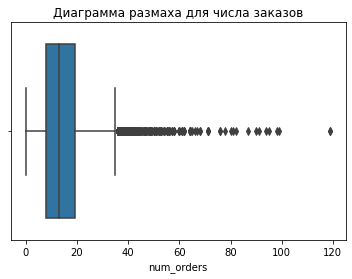

In [4]:
sns.boxplot(x=data["num_orders"]).set(title='Диаграмма размаха для числа заказов');

Максимальное количество заказов - 120, минимальное - 0. Удалить какие-либо данные мы не можем, так как это нарушит хроналогический порядок.

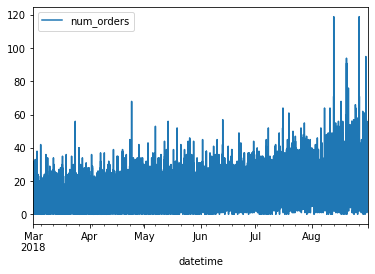

In [5]:
# график для числа заказов
data.plot();

## Анализ

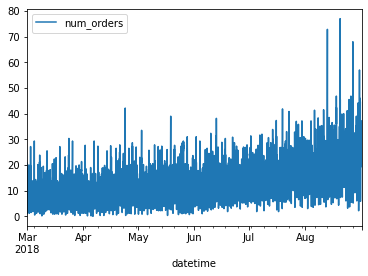

In [6]:
# Ресемплирование данных по одному часу
data = data.resample('1H').mean()
data.plot();

### Тренды и сезонность

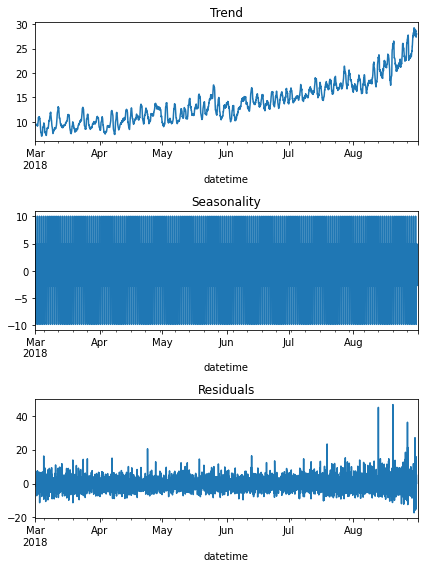

In [7]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

К летним месяцам число заказов такси возрастает. График сезонности интерпретировать сложно, посмотрим график сезонности за первые 7 дней марта.

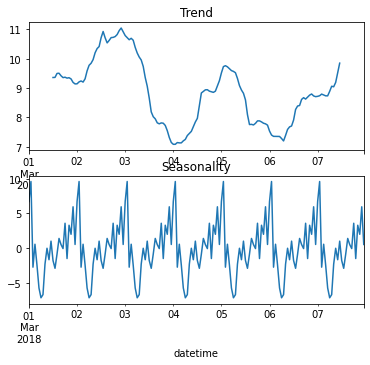

In [8]:
data_1W = data['2018-03-01':'2018-03-07']
decomposed = seasonal_decompose(data_1W)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend');
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality');

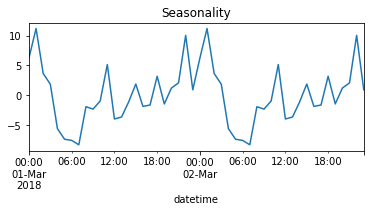

In [9]:
# график сезонности за один день
data_1W = data['2018-03-01':'2018-03-02']
decomposed = seasonal_decompose(data_1W)
plt.figure(figsize=(6, 8))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality');

Мы видим, что каждый день происходит скачок числа заказов такси. Пик приходится на 2-3 часа ночи. Предыдущий график сезонности показывает, что такая картина наблюдается кадый день.

In [10]:
data_2 = data.copy()

Применим тест Дики-Фуллера для подтверждения стационарности ряда.

Гипотезы звучат следующим образом.

* Нулевая гипотеза предполагает, что процесс нестационарный
* Альтернативная гипотеза - процесс стационарный

In [11]:
test = adfuller(data_2)
print('adf_test', test[0])
print('p-value', test[1])
print('Critical values:', test[4])
print(test)
if test[0] > test[4]['5%']:
    print('Ряд не стационарен')
else:
    print('Ряд стационарен')

adf_test -3.0689242890279322
p-value 0.028940051402614794
Critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
(-3.0689242890279322, 0.028940051402614794, 30, 4385, {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}, 26018.566552083048)
Ряд стационарен


Доказали, что ряд стационарен.

## Обучение

### Создание признаков

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['Hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Параметры для функции make_features выбраны случайным образом.

In [13]:
make_features(data, 6, 7)
data.head()

,num_orders,month,day,dayofweek,Hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,20.666667,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,14.166667,3,1,3,1,20.666667,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,11.833333,3,1,3,2,14.166667,20.666667,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,11.000000,3,1,3,3,11.833333,14.166667,20.666667,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,7.166667,3,1,3,4,11.000000,11.833333,14.166667,20.666667,NaN,NaN,NaN


In [14]:
# Разделим на обучающую и тестовую выборку
train, test = train_test_split(data, shuffle=False, test_size=0.1)


print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())
print(f'Размер обучающей выборки: {train.shape}') 
print(f'Размер тестовой выборки: {test.shape}')

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00
Размер обучающей выборки: (3974, 12)
Размер тестовой выборки: (442, 12)


Данные корректно разделились на обучающую и тестовую выборку.

In [15]:
# Удалим значения Nan
train = train.dropna()

In [16]:
# Выделим признаки и целевой признак в отдельные переменные
feature_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
feature_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

### Подбор гиперпараметров для обчуния моделей

#### Модель линейной регрессии 

In [17]:
model = LinearRegression()
model.fit(feature_train, target_train)
predictions = model.predict(feature_train)
RMSE_lr_train = mean_squared_error(target_train, predictions, squared=False)

tscv = TimeSeriesSplit(n_splits=3)

print(f'RMSE на обучающей выборке - {RMSE_lr_train}')

RMSE на обучающей выборке - 5.07034545798121


#### Модель градиентного бустинга

In [18]:
model_cat = CatBoostRegressor(loss_function='RMSE')
parametrs = {'iterations': range(10, 1200),
            'learning_rate': np.arange(0.01, 0.2, 0.01),
            'max_depth': range(1, 10)}

cv = TimeSeriesSplit(n_splits=3).split(train)

model_cat = RandomizedSearchCV(estimator=model_cat, cv=cv,
                        param_distributions=parametrs)

model_cat.fit(feature_train, target_train, verbose=100)
print(model_cat.best_params_)

predictions = model_cat.predict(feature_train)
RMSE_cat = mean_squared_error(target_train, predictions, squared=False)
print(f'RMSE на обучающей выборке - {RMSE_cat}')

0:	learn: 4.6478828	total: 55.5ms	remaining: 42.7s
100:	learn: 1.9016726	total: 240ms	remaining: 1.59s
200:	learn: 1.1672104	total: 412ms	remaining: 1.17s
300:	learn: 0.7736489	total: 558ms	remaining: 871ms
400:	learn: 0.5367698	total: 692ms	remaining: 639ms
500:	learn: 0.3846328	total: 835ms	remaining: 450ms
600:	learn: 0.2793119	total: 1s	remaining: 284ms
700:	learn: 0.1990294	total: 1.17s	remaining: 117ms
770:	learn: 0.1669976	total: 1.29s	remaining: 0us
0:	learn: 5.0655434	total: 2.01ms	remaining: 1.55s
100:	learn: 2.3966334	total: 202ms	remaining: 1.34s
200:	learn: 1.7941936	total: 384ms	remaining: 1.09s
300:	learn: 1.4135364	total: 577ms	remaining: 902ms
400:	learn: 1.1066153	total: 776ms	remaining: 716ms
500:	learn: 0.8767234	total: 983ms	remaining: 530ms
600:	learn: 0.7106904	total: 1.18s	remaining: 334ms
700:	learn: 0.5867161	total: 1.39s	remaining: 139ms
770:	learn: 0.5163003	total: 1.53s	remaining: 0us
0:	learn: 5.3344376	total: 3.91ms	remaining: 3.01s
100:	learn: 2.7183102	

500:	learn: 3.0947563	total: 411ms	remaining: 72.3ms
588:	learn: 3.0186302	total: 485ms	remaining: 0us
0:	learn: 4.6962037	total: 819us	remaining: 275ms
100:	learn: 2.2077735	total: 88.5ms	remaining: 207ms
200:	learn: 1.6152059	total: 180ms	remaining: 122ms
300:	learn: 1.2552501	total: 270ms	remaining: 32.3ms
336:	learn: 1.1453527	total: 302ms	remaining: 0us
0:	learn: 5.0337434	total: 851us	remaining: 286ms
100:	learn: 2.6834350	total: 98.1ms	remaining: 229ms
200:	learn: 2.1804384	total: 188ms	remaining: 127ms
300:	learn: 1.8762157	total: 283ms	remaining: 33.9ms
336:	learn: 1.7887878	total: 338ms	remaining: 0us
0:	learn: 5.3109037	total: 1.17ms	remaining: 393ms
100:	learn: 2.9429168	total: 113ms	remaining: 264ms
200:	learn: 2.5361562	total: 213ms	remaining: 144ms
300:	learn: 2.2499823	total: 316ms	remaining: 37.8ms
336:	learn: 2.1659315	total: 355ms	remaining: 0us
0:	learn: 4.6740640	total: 1.31ms	remaining: 804ms
100:	learn: 1.9770230	total: 108ms	remaining: 549ms
200:	learn: 1.336448

#### Модель RandomForestRegressor, ExtraTreesRegressor

In [19]:
models = [RandomForestRegressor(random_state=12345), 
          ExtraTreesRegressor(random_state=12345)]
RMSE_tree_list = []

for i in models:
    params = {'n_estimators': range (1, 50),
          'max_depth': range (1, 10)}
    
    cv = TimeSeriesSplit(n_splits=3).split(train)
    
    model_tree = RandomizedSearchCV(i, params, cv=cv)
    model_tree.fit(feature_train, target_train)
    print(model_tree.best_params_)

    predictions = model_tree.predict(feature_train)
    RMSE_tree = mean_squared_error(target_train, predictions, squared=False)
    RMSE_tree_list.append(RMSE_tree)
    print(f'RMSE на обучающей выборке - {RMSE_tree}')

{'n_estimators': 43, 'max_depth': 9}
RMSE на обучающей выборке - 2.8610122592731866
{'n_estimators': 22, 'max_depth': 9}
RMSE на обучающей выборке - 3.1635251108994193


## Тестирование

In [20]:
results = pd.DataFrame({'Regresson' : [],
                        'RMSE на обучающей выборке' : [], 
                        'RMSE на тестовой выборке' : [],
                       })

In [21]:
# Модель линейной регрессии
model = LinearRegression()
model.fit(feature_train, target_train)
predictions_lr = model.predict(feature_test)
RMSE_lr = mean_squared_error(target_test, predictions_lr, squared=False)

results = results.append({'Regresson' : 'LinearRegression',
                        'RMSE на обучающей выборке' : RMSE_lr_train, 
                        'RMSE на тестовой выборке' : RMSE_lr,
                       }, ignore_index=True)
print(RMSE_lr)

8.779962935616378


/var/folders/vf/z1gk_tyn2zsf73w6bspmxgjm0000gn/T/ipykernel_73063/1304511604.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Regresson' : 'LinearRegression',


In [22]:
# модель RandomForestRegressor
model = RandomForestRegressor(n_estimators = 44, max_depth = 9)
model.fit(feature_train, target_train)

predictions_rand = model.predict(feature_test)

RMSE_test_tree = mean_squared_error(target_test, predictions_rand, squared=False)

print(RMSE_test_tree)
results = results.append({'Regresson' : 'RandomForestRegressor', 
                       'RMSE на обучающей выборке' : RMSE_tree_list[0], 
                       'RMSE на тестовой выборке' : RMSE_test_tree}, ignore_index=True)

8.158045379853819


/var/folders/vf/z1gk_tyn2zsf73w6bspmxgjm0000gn/T/ipykernel_73063/373944943.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Regresson' : 'RandomForestRegressor',


In [23]:
# модель ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators = 40, max_depth = 7)
model.fit(feature_train, target_train)

predictions_tree = model.predict(feature_test)

RMSE_test_tree_2 = mean_squared_error(target_test, predictions_tree, squared=False)

print(RMSE_test_tree_2)
results = results.append({'Regresson' : 'RandomForestRegressor', 
                       'RMSE на обучающей выборке' : RMSE_tree_list[1], 
                       'RMSE на тестовой выборке' : RMSE_test_tree_2}, ignore_index=True)

8.0317942597451


/var/folders/vf/z1gk_tyn2zsf73w6bspmxgjm0000gn/T/ipykernel_73063/3323132064.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Regresson' : 'RandomForestRegressor',


In [24]:
# градиентный бустинг
model_cat = CatBoostRegressor(loss_function='RMSE', iterations =910, learning_rate =0.02, max_depth= 6)

model_cat.fit(feature_train, target_train, verbose=100)

predictions_cat = model_cat.predict(feature_test)
RMSE_test_cat = mean_squared_error(target_test, predictions_cat, squared=False)

print(RMSE_test_cat)


results = results.append({'Regresson' : 'CatBoostRegressor', 
                       'RMSE на обучающей выборке' : RMSE_cat, 
                       'RMSE на тестовой выборке' : RMSE_test_cat}, ignore_index=True)

0:	learn: 6.3833508	total: 2.39ms	remaining: 2.17s
100:	learn: 4.1747522	total: 165ms	remaining: 1.32s
200:	learn: 3.8519782	total: 327ms	remaining: 1.15s
300:	learn: 3.6669764	total: 521ms	remaining: 1.05s
400:	learn: 3.5265649	total: 675ms	remaining: 856ms
500:	learn: 3.4166844	total: 821ms	remaining: 670ms
600:	learn: 3.2925013	total: 993ms	remaining: 511ms
700:	learn: 3.1676617	total: 1.15s	remaining: 342ms
800:	learn: 3.0672555	total: 1.32s	remaining: 180ms
900:	learn: 2.9870699	total: 1.5s	remaining: 15ms
909:	learn: 2.9800233	total: 1.52s	remaining: 0us
7.337777568141313


/var/folders/vf/z1gk_tyn2zsf73w6bspmxgjm0000gn/T/ipykernel_73063/1931869306.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Regresson' : 'CatBoostRegressor',


In [25]:
results

,Regresson,RMSE на обучающей выборке,RMSE на тестовой выборке
0,LinearRegression,5.070345,8.779963
1,RandomForestRegressor,2.861012,8.158045
2,RandomForestRegressor,3.163525,8.031794
3,CatBoostRegressor,2.527476,7.337778


# Вывод

В рамках проекта были изучены исторические данные о числе заказов такси. Было выявлено, что каждый день пик по численность заказов приходится на 2-3 часа ночи, а в летние месяцы число заказов возрастает.

На основе этих данных были обучены несколько моделей, наилучшей из которых оказалась модель градиентного спуска. На тестовой выборке значение метрики RMSE составило 7.33. Полученная модель может прогнозировать количество заказов такси на следующий час.

На графике ниже видно, что все модели достаточно близки к реальным значениям.

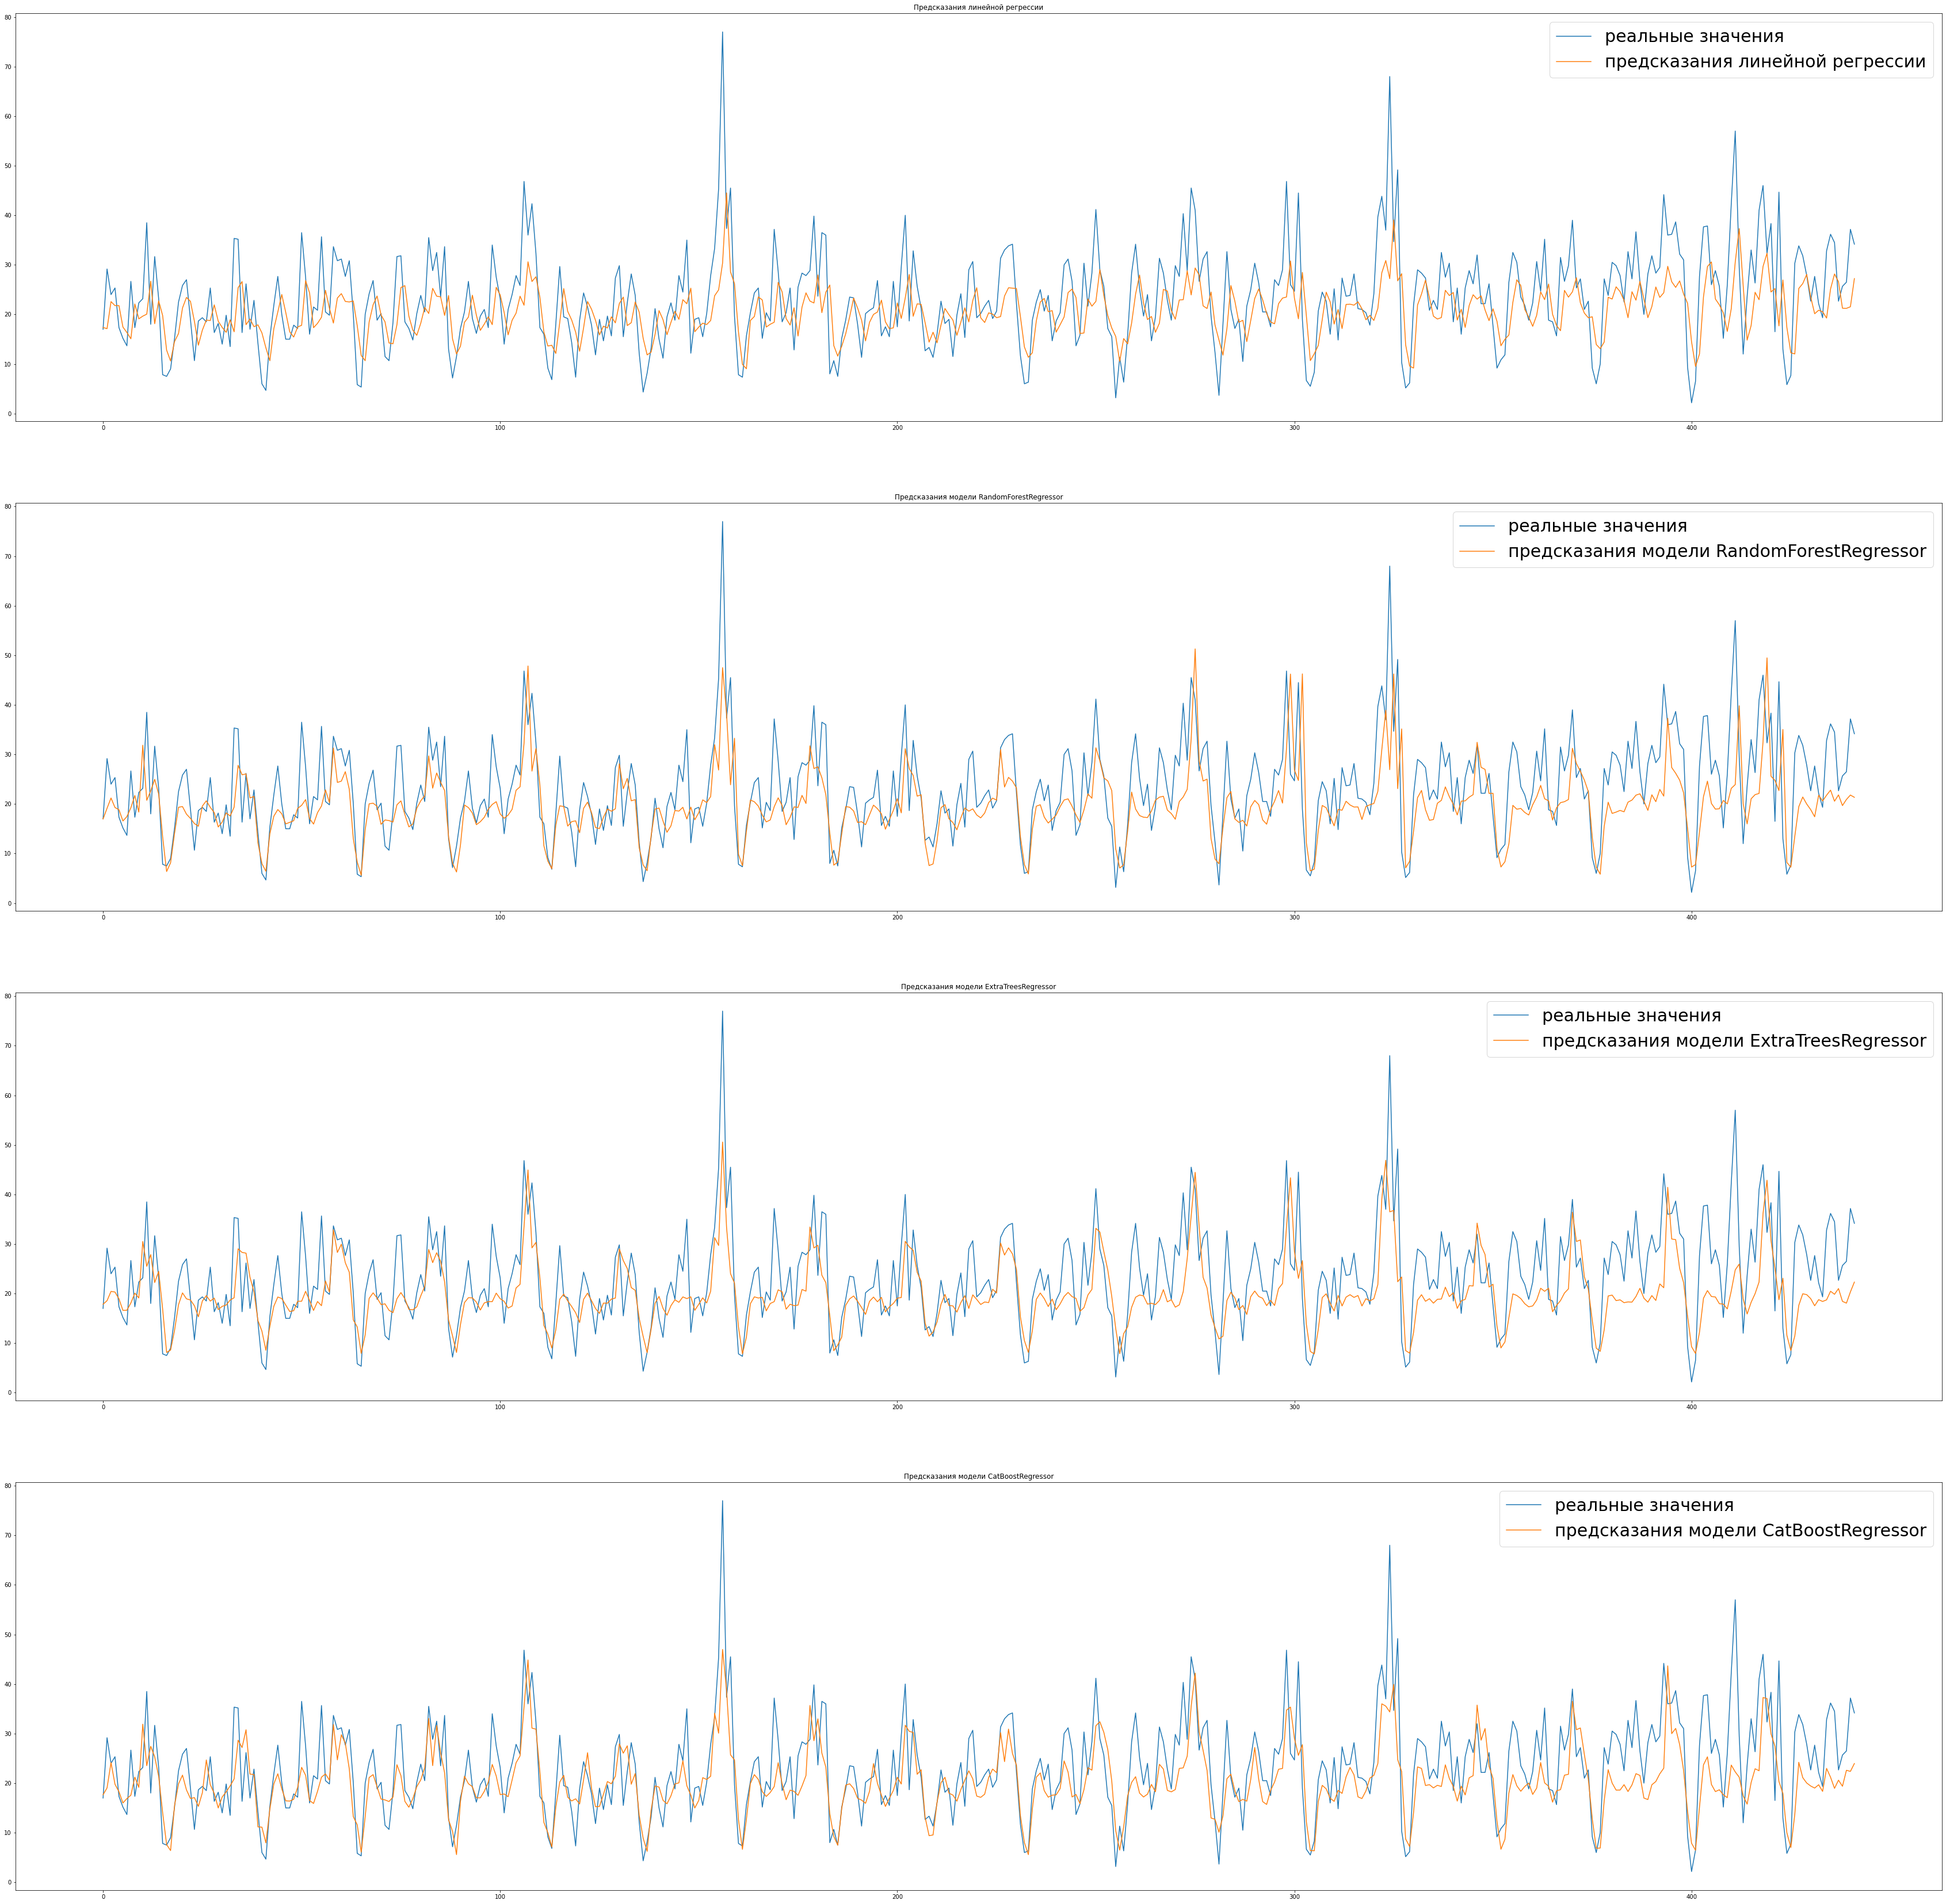

In [27]:
plt.figure(figsize=(60, 60))

plt.subplot(4,1,1)

plt.plot(target_test.values, label='реальные значения')
plt.plot(predictions_lr, label ='предсказания линейной регрессии')
plt.title('Предсказания линейной регрессии')
plt.legend(fontsize=30)

plt.subplot(4,1,2)
plt.plot(target_test.values, label='реальные значения')
plt.plot(predictions_rand, label ='предсказания модели RandomForestRegressor')
plt.title('Предсказания модели RandomForestRegressor')
plt.legend(fontsize=30)

plt.subplot(4,1,3)
plt.plot(target_test.values, label='реальные значения')
plt.plot(predictions_tree, label = 'предсказания модели ExtraTreesRegressor')
plt.title('Предсказания модели ExtraTreesRegressor')
plt.legend(fontsize=30)

plt.subplot(4,1,4)
plt.plot(target_test.values, label='реальные значения')
plt.plot(predictions_cat, label='предсказания модели CatBoostRegressor')
plt.title('Предсказания модели CatBoostRegressor')
plt.legend(fontsize=30)

plt.show()